### For selected ClearCut AOI prepare PlanetScope and Sentinel2 images. Show clearcuts on AOI. Compare quality

In [1]:
import os
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio.mask
import tempfile
import shapely
import re

from rasterio.features import rasterize, shapes
from shapely.geometry import Polygon, shape, box
from pathlib import Path
from datetime import datetime

from sentinel2download.downloader import Sentinel2Downloader

In [2]:
NB_USER = os.getenv('NB_USER')

In [3]:
PATH = f"/home/{NB_USER}/work/notebooks/planet"

In [9]:
PLANET_METADATA = f"{PATH}/global_meta.geojson"

In [11]:
planet_tiles = gpd.read_file(PLANET_METADATA, driver="GeoJSON")
planet_tiles.head(1)

,id,acquired,anomalous_pixels,black_fill,cloud_cover,columns,epsg_code,grid_cell,ground_control,gsd,...,clear_percent,cloud_percent,heavy_haze_percent,light_haze_percent,shadow_percent,snow_ice_percent,visible_confidence_percent,visible_percent,year,geometry
0,1336590_3761711_2018-04-08_1021,2018-04-08T07:51:44,0.01,0.34,0.006,8000,32637,3761711,1,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,"POLYGON ((37.68174 48.95690, 37.67582 49.18171..."


In [12]:
sentinel_tiles_path = "sentinel2grid.geojson"

In [13]:
sentinel_tiles = gpd.read_file(sentinel_tiles_path)
sentinel_tiles.head()

,Name,geometry
0,01CCV,"POLYGON Z ((180.000 -73.060 0.000, 176.865 -72..."
1,01CCV,"POLYGON Z ((-180.000 -72.073 0.000, -179.627 -..."
2,01CDH,"POLYGON Z ((180.000 -83.809 0.000, 174.713 -83..."
3,01CDH,"POLYGON Z ((-180.000 -82.826 0.000, -176.297 -..."
4,01CDJ,"POLYGON Z ((180.000 -82.913 0.000, 175.748 -82..."


In [209]:
aoi = gpd.read_file("selected_AoI.geojson") 

In [210]:
aoi

,id,geometry
0,None,"MULTIPOLYGON (((35.27423 50.12803, 35.41354 50..."
1,None,"MULTIPOLYGON (((35.08580 50.17168, 35.18946 50..."
2,None,"MULTIPOLYGON (((37.62633 50.06614, 38.03014 50..."


In [16]:
def filter_planet(grid):
    grid = grid.loc[(grid.ground_control == "1") & 
                    (grid.item_type == "PSScene4Band") &
                    (grid.quality_category == "standard") &
                    (grid.cloud_cover == 0) &
                    (grid.year.astype(int) >= 2018)&
                    (grid.snow_ice_percent == 0) &
                    (grid.clear_percent >= 95)].reset_index(drop=True)
    return grid

In [17]:
planet_grid = filter_planet(planet_tiles)

In [18]:
planet_grid.head(1)

,id,acquired,anomalous_pixels,black_fill,cloud_cover,columns,epsg_code,grid_cell,ground_control,gsd,...,clear_percent,cloud_percent,heavy_haze_percent,light_haze_percent,shadow_percent,snow_ice_percent,visible_confidence_percent,visible_percent,year,geometry
0,20180618_074503_104e,2018-06-18T07:45:03,0.0,NaN,0.0,8364,32636,None,1,3.6,...,100.0,0.0,0.0,0.0,0.0,0.0,75.0,100.0,2018,"POLYGON ((34.67585 49.86933, 34.66087 49.91075..."


In [19]:
def epsg_code(longitude, latitude):
    """
    Generates EPSG code from lon, lat
    :param longitude: float
    :param latitude: float
    :return: int, EPSG code
    """

    def _zone_number(lat, lon):
        if 56 <= lat < 64 and 3 <= lon < 12:
            return 32
        if 72 <= lat <= 84 and lon >= 0:
            if lon < 9:
                return 31
            elif lon < 21:
                return 33
            elif lon < 33:
                return 35
            elif lon < 42:
                return 37

        return int((lon + 180) / 6) + 1

    zone = _zone_number(latitude, longitude)

    if latitude > 0:
        return 32600 + zone
    else:
        return 32700 + zone

In [182]:
def _intersect(aoi, grid, limit=1):
    """
    Find all tiles that intersects given region with area >= limit km2
    :param limit: float, min intersection area in km2
    :return: (GeoDataFrame, epsg), precised intersected tiles and UTM zone code
    """

    
    # Get the indices of the tiles that are likely to be inside the bounding box of the given Polygon
    geometry = aoi.geometry[0]

    tiles_indexes = list(grid.sindex.intersection(geometry.bounds))
    intersected_grid = grid.loc[tiles_indexes]

    # Make the precise tiles in Polygon query
    intersected_grid = intersected_grid.loc[grid.intersects(geometry)]

    # intersection area
    epsg = epsg_code(geometry.centroid.x, geometry.centroid.y)

    # to UTM projection in meters
    aoi['geometry'] = aoi.geometry.to_crs(epsg=epsg)
    intersected_grid['geometry'] = intersected_grid.geometry.to_crs(epsg=epsg)

    intersected_grid['area'] = intersected_grid.geometry.apply(lambda g: g.intersection(aoi.geometry[0]).area / 1e6)

    intersected_grid = intersected_grid.loc[intersected_grid['area'] >= limit]
    intersected_grid = intersected_grid.sort_values(by='area', ascending=False)

    return intersected_grid, epsg

In [198]:
bbox = box(*aoi.total_bounds)
bbox = gpd.GeoDataFrame(geometry=[bbox], crs="epsg:4326")

In [192]:
bbox

,geometry
0,"POLYGON ((430904.371 5513198.558, 431484.158 5..."


In [185]:
planet_intersected, epsg = _intersect(bbox, planet_grid)

In [189]:
sin, epsg = _intersect(bbox, sentinel_tiles)

In [190]:
sin.to_file(f"/home/{NB_USER}/work/notebooks/planet/37UDR.geojson", driver='GeoJSON')

,Name,geometry,area
34230,36UYA,"POLYGON Z ((274633.875 5601067.675 0.000, 3840...",4969.360030
35116,37UCR,"POLYGON Z ((300000.000 5600040.000 0.000, 4098...",4967.793448
34221,36UXA,"POLYGON Z ((174935.494 5609149.063 0.000, 2844...",2730.416141
35125,37UDR,"POLYGON Z ((399960.000 5600040.000 0.000, 5097...",1412.795662


In [127]:
planet_intersected.tail(1)

,id,acquired,anomalous_pixels,black_fill,cloud_cover,columns,epsg_code,grid_cell,ground_control,gsd,...,cloud_percent,heavy_haze_percent,light_haze_percent,shadow_percent,snow_ice_percent,visible_confidence_percent,visible_percent,year,geometry,area
35,20180824_073455_1020,2018-08-24T07:34:55,0.0,NaN,0.0,8455,32636,None,1,3.7,...,0.0,0.0,0.0,0.0,0.0,68.0,100.0,2018,"POLYGON ((195249.089 5535690.663, 194700.261 5...",1.001674


In [62]:
planet = planet_intersected[['id', 'acquired', 'geometry', 'area']]

In [63]:
planet.tail(1)

,id,acquired,geometry,area
35,20180824_073455_1020,2018-08-24T07:34:55,"POLYGON ((195249.089 5535690.663, 194700.261 5...",1.001674


In [137]:
def overlap(bound_box, grid, *, limit: float = 0.001):
    """
    Find unique tiles that intersects given aoi, area
    :param limit: float, min intersection area in km2
    :return: list, list of tiles
    """

    intersected_grid, epsg = _intersect(bound_box, grid)
    print(intersected_grid)
    print(bound_box)

    aoi = bound_box.copy()
    overlap_tiles = list()
    for row in intersected_grid.itertuples():
        start_area = aoi.geometry[0].area
        instersection_geometry = aoi.geometry[0].intersection(row.geometry)
        aoi.geometry[0] = aoi.geometry[0].difference(row.geometry)
        print("START AREA", start_area)
        print("END AREA", aoi.geometry[0].area)
        
        print("INTERSECTION GEOMETRY", instersection_geometry)
        if start_area != aoi.geometry[0].area:
            overlap_tiles.append(dict(Name=row.Name, geometry=instersection_geometry))

    if not overlap_tiles:
        return

    tiles = gpd.GeoDataFrame(overlap_tiles, crs=epsg)
    tiles = tiles.to_crs("epsg:4326")

    
    return tiles

In [144]:
b = bbox.copy()

In [145]:
b

,geometry
0,"POLYGON ((38.04050 49.76728, 38.04050 50.17392..."


In [146]:
stiles = overlap(b, sentinel_tiles)

        Name                                           geometry         area
34230  36UYA  POLYGON Z ((274633.875 5601067.675 0.000, 3840...  4969.360030
35116  37UCR  POLYGON Z ((300000.000 5600040.000 0.000, 4098...  4967.793448
34221  36UXA  POLYGON Z ((174935.494 5609149.063 0.000, 2844...  2730.416141
35125  37UDR  POLYGON Z ((399960.000 5600040.000 0.000, 5097...  1412.795662
                                            geometry
0  POLYGON ((430904.371 5513198.558, 431484.158 5...
START AREA 9586715289.184702
END AREA 4617355259.048197
INTERSECTION GEOMETRY POLYGON Z ((271622.32592192 5563634.889476194 0, 381441.0127221352 5560044.819316789 0, 377812.6482019669 5514923.862967169 0, 267990.5404006586 5518492.717384906 0, 271622.32592192 5563634.889476194 0))
START AREA 4617355259.048197
END AREA 3252433371.6243362
INTERSECTION GEOMETRY POLYGON Z ((381441.0127221352 5560044.819316789 0, 409800.0000023523 5559117.738899493 0, 409800.0000082137 5513884.38007897 0, 377812.6482019669 55

In [147]:
stiles

,Name,geometry
0,36UYA,"POLYGON Z ((35.80104 50.18082 0.00000, 37.3394..."
1,37UCR,"POLYGON Z ((37.33942 50.18073 0.00000, 37.7367..."
2,36UXA,"POLYGON Z ((35.77747 49.77405 0.00000, 35.0855..."
3,37UDR,"POLYGON Z ((37.73673 50.17739 0.00000, 38.0405..."


In [66]:
aoi

,id,geometry
0,None,"MULTIPOLYGON (((35.27423 50.12803, 35.41354 50..."
1,None,"MULTIPOLYGON (((35.08580 50.17168, 35.18946 50..."
2,None,"MULTIPOLYGON (((37.62633 50.06614, 38.03014 50..."


In [67]:
start_area = bbox.geometry[0].area

In [73]:
start_area

9586715289.184702

In [77]:
print(planet.iloc[0].geometry)

POLYGON ((284448.64255735 5551523.353719053, 287794.1144414392 5534581.319095265, 313284.2648012205 5539584.88111339, 309939.2510644832 5556574.093072873, 284448.64255735 5551523.353719053))


In [75]:
planet.head(1)

,id,acquired,geometry,area
299,20191008_080906_11_1065,2019-10-08T08:09:06,"POLYGON ((284448.643 5551523.354, 287794.114 5...",449.277215


In [88]:
b.geometry[0] = b.geometry[0].difference(planet.iloc[1].geometry)
b

,geometry
0,"POLYGON ((430904.371 5513198.558, 218148.149 5..."


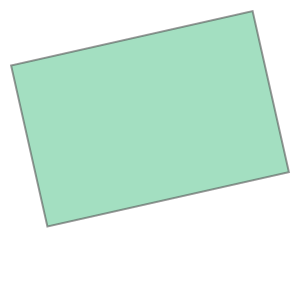

In [93]:
b.geometry[0].intersection(planet.iloc[2].geometry)

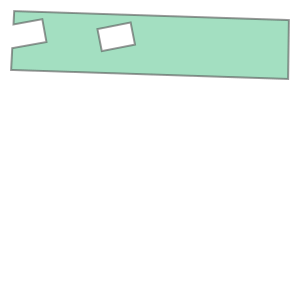

In [89]:
b.geometry[0] 

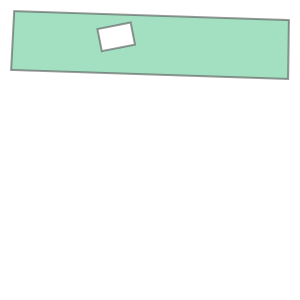

In [87]:
b.geometry[0] 

In [ ]:
intersected_grid = intersected_grid.loc[grid.intersects(geometry)]

In [90]:
sentinel_tiles.loc[sentinel_tiles.Name == '35UQP']

,Name,geometry
33263,35UQP,"POLYGON Z ((29.71882 48.72093 0.00000, 31.2082..."


In [196]:
def get_tiles(bbox, sentinel_tiles_path):
    '''
    Returns Sentinel-2 tiles that intersects with specified AoI.

    '''
    aoi_file = bbox #gpd.read_file(aoi_path)
    sentinel_tiles = gpd.read_file(sentinel_tiles_path)
    sentinel_tiles.set_index("Name", drop=False, inplace=True)

    best_interseciton = {"tileID": [], "geometry": []}
    rest_aoi = aoi_file.copy()

    while rest_aoi.area.sum() > 0:
        res_intersection = gpd.overlay(rest_aoi, sentinel_tiles, how="intersection")
        biggest_area_idx = res_intersection.area.argmax()

        tileID = res_intersection.loc[biggest_area_idx, "Name"]
        this_aoi = res_intersection.loc[biggest_area_idx, "geometry"]

        best_interseciton["tileID"].append(tileID)
        best_interseciton["geometry"].append(this_aoi)

        biggest_intersection = sentinel_tiles.loc[[tileID]]
        rest_aoi = gpd.overlay(rest_aoi, biggest_intersection, how="difference")
        sentinel_tiles = sentinel_tiles.loc[res_intersection["Name"]]

    date_tile_info = gpd.GeoDataFrame(best_interseciton)
    date_tile_info.crs = aoi_file.crs
    
    return date_tile_info


In [228]:
def get_tiles(sin, bbox):
    '''
    Returns Sentinel-2 tiles that intersects with specified AoI.

    '''
    aoi_file = bbox
    sentinel_tiles = sin
    sentinel_tiles.set_index("id", drop=False, inplace=True)
    # print(sentinel_tiles)

    best_interseciton = {"tileID": [], "geometry": []}
    rest_aoi = aoi_file.copy()

    while rest_aoi.area.sum() > 0:
        res_intersection = gpd.overlay(rest_aoi, sentinel_tiles, how="intersection")
        biggest_area_idx = res_intersection.area.argmax()

        tileID = res_intersection.loc[biggest_area_idx, "id"]
        this_aoi = res_intersection.loc[biggest_area_idx, "geometry"]

        best_interseciton["tileID"].append(tileID)
        best_interseciton["geometry"].append(this_aoi)

        biggest_intersection = sentinel_tiles.loc[[tileID]]
        rest_aoi = gpd.overlay(rest_aoi, biggest_intersection, how="difference")
        sentinel_tiles = sentinel_tiles.loc[res_intersection["id"]]

    date_tile_info = gpd.GeoDataFrame(best_interseciton)
    date_tile_info.crs = aoi_file.crs
    
    return date_tile_info

In [223]:
planet_tiles

,id,acquired,anomalous_pixels,black_fill,cloud_cover,columns,epsg_code,grid_cell,ground_control,gsd,...,clear_percent,cloud_percent,heavy_haze_percent,light_haze_percent,shadow_percent,snow_ice_percent,visible_confidence_percent,visible_percent,year,geometry
0,1336590_3761711_2018-04-08_1021,2018-04-08T07:51:44,0.01,0.34,0.006,8000,32637,3761711,1,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,"POLYGON ((37.68174 48.95690, 37.67582 49.18171..."
1,1336590_3761811_2018-04-08_1021,2018-04-08T07:51:41,0.01,0.10,0.012,8000,32637,3761811,1,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,"POLYGON ((37.67603 49.17274, 37.67002 49.39752..."
2,1336590_3761911_2018-04-08_1021,2018-04-08T07:51:38,0.01,0.14,0.007,8000,32637,3761911,1,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,"POLYGON ((37.67025 49.38852, 37.66974 49.40701..."
3,1336590_3761912_2018-04-08_1021,2018-04-08T07:51:37,0.00,0.78,0.002,8000,32637,3761912,1,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,"POLYGON ((38.00088 49.39190, 37.99633 49.61669..."
4,1336590_3762011_2018-04-08_1021,2018-04-08T07:51:35,0.01,0.38,0.011,8000,32637,3762011,1,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,"POLYGON ((37.74534 49.60515, 37.82808 49.83089..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5441,764087_3761816_2017-09-17_0f38,2017-09-17T07:35:24,0.00,0.12,0.001,8000,32637,3761816,1,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,"POLYGON ((39.57334 49.17874, 39.32245 49.17987..."
5442,764087_3761915_2017-09-17_0f38,2017-09-17T07:35:22,0.00,0.96,0.000,8000,32637,3761915,1,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,"POLYGON ((39.32507 49.39568, 39.29348 49.39601..."
5443,764087_3761916_2017-09-17_0f38,2017-09-17T07:35:21,0.00,0.06,0.000,8000,32637,3761916,1,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,"POLYGON ((39.65878 49.39427, 39.32386 49.39572..."
5444,764087_3761917_2017-09-17_0f38,2017-09-17T07:35:20,0.00,0.85,0.000,8000,32637,3761917,1,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,"POLYGON ((39.66190 49.39425, 39.65460 49.39436..."


In [208]:
aoi

,id,geometry
0,None,"MULTIPOLYGON (((35.27423 50.12803, 35.41354 50..."
1,None,"MULTIPOLYGON (((35.08580 50.17168, 35.18946 50..."
2,None,"MULTIPOLYGON (((37.62633 50.06614, 38.03014 50..."


In [212]:
r = gpd.overlay(aoi, sentinel_tiles, how="intersection")

In [217]:
r

,id,Name,geometry
0,None,36UXA,"POLYGON Z ((35.27423 50.12803 0.00000, 35.4135..."
1,None,36UXA,"POLYGON Z ((35.08580 50.17168 0.00000, 35.1894..."
2,None,37UCR,"POLYGON Z ((37.62633 50.06614 0.00000, 37.7395..."
3,None,37UDR,"POLYGON Z ((37.62633 50.06614 0.00000, 38.0301..."


In [213]:
r.area

/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


0    0.010529
1    0.007017
2    0.034495
3    0.119918
dtype: float64

In [216]:
biggest_area_idx = r.area.argmax()
tileID = r.loc[biggest_area_idx, "Name"]
tileID

/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


'37UDR'

In [195]:
get_tiles(sin, bbox)

/opt/conda/envs/python37/lib/python3.7/site-packages/geopandas/tools/overlay.py:60: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]
/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  from ipykernel import kernelapp as a

,tileID,geometry
0,36UYA,"POLYGON Z ((377812.648 5514923.863 0.000, 2679..."
1,36UXA,"POLYGON Z ((267990.540 5518492.717 0.000, 2181..."
2,37UDR,"POLYGON Z ((430904.371 5513198.558 0.000, 3999..."
3,37UCR,"POLYGON Z ((399960.000 5514204.147 0.000, 3778..."


In [199]:
bbox

,geometry
0,"POLYGON ((38.04050 49.76728, 38.04050 50.17392..."


In [ ]:
stiles

In [200]:
st = get_tiles(bbox, "sentinel2grid.geojson")

/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]
/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  from ipykernel import kernelapp as app
/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]
/opt/conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area

In [201]:
st

,tileID,geometry
0,36UYA,"POLYGON Z ((37.30265 49.76728 0.00000, 35.7772..."
1,36UXA,"POLYGON Z ((35.77721 49.76728 0.00000, 35.0855..."
2,37UDR,"POLYGON Z ((38.04050 49.76728 0.00000, 37.6106..."
3,37UCR,"POLYGON Z ((37.61064 49.76728 0.00000, 37.3026..."


In [204]:
sentinel_tiles.loc[sentinel_tiles.Name == '36UYA']

,Name,geometry
34230,36UYA,"POLYGON Z ((35.82077 50.51811 0.00000, 37.3657..."


In [150]:
st

,tileID,geometry
0,37UDR,"POLYGON Z ((37.62633 50.06614 0.00000, 38.0301..."
1,36UXA,"POLYGON Z ((35.27423 50.12803 0.00000, 35.4135..."


In [232]:
stiles

,Name,geometry
0,36UYA,"POLYGON Z ((35.80104 50.18082 0.00000, 37.3394..."
1,37UCR,"POLYGON Z ((37.33942 50.18073 0.00000, 37.7367..."
2,36UXA,"POLYGON Z ((35.77747 49.77405 0.00000, 35.0855..."
3,37UDR,"POLYGON Z ((37.73673 50.17739 0.00000, 38.0405..."


In [231]:
gpd.overlay(aoi, stiles, how="intersection")

,id,Name,geometry
0,None,36UXA,"POLYGON Z ((35.27423 50.12803 0.00000, 35.4135..."
1,None,36UXA,"POLYGON Z ((35.08580 50.17168 0.00000, 35.1894..."
2,None,37UCR,"POLYGON Z ((37.62633 50.06614 0.00000, 37.7396..."
3,None,37UDR,"POLYGON Z ((37.73969 50.06390 0.00000, 38.0301..."


In [ ]:
['36UXA', '36UYA', '37UCR', '37UDR']

In [157]:
s = sentinel_tiles.loc[sentinel_tiles.Name.isin(['36UXA', '36UYA', '37UCR', '37UDR'])]

In [159]:
s.to_file(f"/home/{NB_USER}/work/notebooks/planet/tiles.geojson", driver='GeoJSON')

In [162]:
s.iloc[0].to_file?

Object `to_file` not found.


In [169]:
s1 = s.head(2)
s1

,Name,geometry
34221,36UXA,"POLYGON Z ((34.41135 50.54374 0.00000, 35.9593..."
34230,36UYA,"POLYGON Z ((35.82077 50.51811 0.00000, 37.3657..."


In [177]:
s1

,Name,geometry
34221,36UXA,"POLYGON Z ((34.41135 50.54374 0.00000, 35.9593..."
34230,36UYA,"POLYGON Z ((35.82077 50.51811 0.00000, 37.3657..."


In [180]:
s[3:4]

,Name,geometry
35125,37UDR,"POLYGON Z ((37.58809 50.54373 0.00000, 39.1377..."


In [173]:
s1[:1]

,Name,geometry
34221,36UXA,"POLYGON Z ((34.41135 50.54374 0.00000, 35.9593..."


In [181]:
s[2:3].to_file(f"/home/{NB_USER}/work/notebooks/planet/37UDR.geojson", driver='GeoJSON')

In [ ]:
class PlanetTilesSelection:
    def __init__(self):
        gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
        self.planet = gpd.read_file(META_INFO, driver="GeoJSON")
        self.sentinel_meta = gpd.read_file(SENTINEL_TILES, driver="kml")
    def planet_quality_filter(self):
        self.planet = self.planet[self.planet["ground_control"] == "1"]
        self.planet = self.planet[self.planet["item_type"] == "PSScene4Band"]
        self.planet = self.planet[self.planet['quality_category'] == "standard"]
        self.planet = self.planet[self.planet['cloud_cover'] == 0]
        self.planet = self.planet[self.planet['year'].astype(int) >= 2018]
        
        
    def match_planet_sentinel(self, planet_tile_id):
        selected_tile = self.planet[self.planet['id'] == planet_tile_id]
        planet_bounds = get_box(selected_tile)
        self.sentinel_meta = self.sentinel_meta[self.sentinel_meta['geometry'].intersects(planet_bounds)]
        matched_tiles = self.sentinel_meta['Name'].unique()
        print(matched_tiles)
        # self.sentinel_meta.to_file("./data/matched_tiles.geojson", driver='GeoJSON')
        return matched_tiles